# Unit 5 - Financial Planning


In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json
from datetime import date

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv('api_keys.env')

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [5]:
# Fetch current BTC price
btc_response = requests.get(btc_url)
btc_data = btc_response.json()
btc_price = btc_data['data']['1']['quotes']['USD']['price']

# Fetch current ETH price
eth_response = requests.get(eth_url)
eth_data = eth_response.json()
eth_price = eth_data['data']['1027']['quotes']['USD']['price']

# Compute current value of my crpto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $67309.20
The current value of your 5.3 ETH is $9095.22


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [8]:
# Format current date as ISO format
#today = pd.Timestamp(date.today(), tz="America/New_York").isoformat()
today = pd.Timestamp('2021-03-26', tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
df_portfolio = api.get_barset(
    tickers,
    timeframe,
    start = today,
    end = today
).df

# Preview DataFrame
df_portfolio

AGG                                       SPY  \
                             open     high     low   close   volume    open   
time                                                                          
2021-03-26 00:00:00-04:00  113.91  114.075  113.86  113.93  3287634  390.93   

                                                             
                             high     low   close    volume  
time                                                         
2021-03-26 00:00:00-04:00  396.41  390.29  395.99  90959116

In [9]:
# Pick AGG and SPY close prices
#agg_close_price = df_portfolio['AGG']['close']
agg_close_price = df_portfolio.iloc[0][3]
#spy_close_price = df_portfolio['SPY']['close']
spy_close_price = df_portfolio.iloc[0][8]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $113.93
Current SPY closing price: $395.99


In [10]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of share
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $19799.50
The current value of your 200 AGG shares is $22786.00


### Savings Health Analysis

In [11]:
# Set monthly household income
monthly_income = 12000

# Create savings DataFrame
df_savings = pd.DataFrame({"amount":[my_btc_value+my_eth_value,my_spy_value+my_agg_value]})
df_savings.index = ['crypto','shares']

# Display savings DataFrame
display(df_savings)

,amount
crypto,76404.424
shares,42585.500


<AxesSubplot:ylabel='amount'>

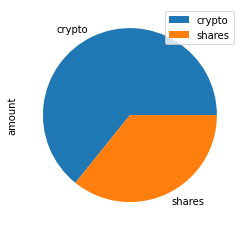

In [12]:
# Plot savings pie chart
df_savings.plot.pie(y='amount')

In [13]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings['amount'].sum()

# Validate saving health
if total_savings > emergency_fund:
    print('Congratulations you have enough money in your fund!')
elif total_savings == emergency_fund:
    print('Congratulations on reaching your goal!')
elif total_savings < emergency_fund:
    print(f'You are ${emergency_fund-total_savings} away from reaching the goal')

Congratulations you have enough money in your fund!


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-03-26', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-03-26', tz='America/New_York').isoformat()

In [15]:
# Get 5 years' worth of historical data for SPY and AGG
tickers = ['SPY', 'AGG']
df_stock_data = api.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=1000,
).df

# Display sample data
df_stock_data.head()

AGG                                        SPY  \
                             open    high       low   close   volume    open   
time                                                                           
2017-04-06 00:00:00-04:00  108.64  108.71  108.4800  108.67  1599535  234.95   
2017-04-07 00:00:00-04:00  108.80  108.89  108.4200  108.44  1668826  235.15   
2017-04-10 00:00:00-04:00  108.53  108.65  108.4901  108.57  1751500  235.36   
2017-04-11 00:00:00-04:00  108.76  108.98  108.7500  108.90  2054745  234.87   
2017-04-12 00:00:00-04:00  108.93  109.20  108.8900  109.14  2243678  234.74   

                                                               
                              high      low   close    volume  
time                                                           
2017-04-06 00:00:00-04:00  236.040  234.425  235.39  53559902  
2017-04-07 00:00:00-04:00  236.000  234.640  235.17  53293901  
2017-04-10 00:00:00-04:00  236.255  234.730  235.32  46610548  
2017-04-11 00:00:00-04:00  235.180  233.340  235.04  63951745  
2017-04-12 00:00:00-04:00  234.960  233.770  234.10  55338215

In [16]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
#Set number of simulations
num_sims = 500

# Configure a Monte Carlo simulation to forecast three years daily returns
MC_thirty_year = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.4,0.6],
    num_simulation = num_sims,
    num_trading_days = 252 * 30
)

In [17]:
# Printing the simulation input data


In [18]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirty_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.991675,0.995626,1.013392,1.005113,0.991527,0.991549,1.002179,1.007175,1.000069,1.002662,...,0.991508,1.002770,0.995098,0.993457,1.000984,0.994313,0.997466,1.008094,1.009282,0.995774
2,0.986793,1.006891,1.025244,1.012677,0.996536,0.997870,1.010823,1.002064,0.991717,1.001828,...,1.002777,1.015945,0.998633,1.001827,1.000546,0.995871,0.989006,1.004199,1.008434,1.007125
3,0.980618,1.005897,1.045467,1.007642,0.982207,1.002420,1.001262,1.000917,0.990394,0.995294,...,0.997624,1.019968,1.003976,1.009768,1.003019,1.000703,0.998041,1.017954,0.993500,1.010435
4,0.973213,1.008768,1.051655,0.999143,0.980868,0.994013,1.014645,0.997730,1.000686,1.002188,...,0.999802,1.024507,1.009072,1.030964,1.007603,1.001113,1.007433,1.023819,0.995442,1.017820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,20.678939,28.980708,6.735699,7.194222,12.237593,5.415896,29.064411,57.823529,10.407945,6.281341,...,31.776073,10.196039,14.216462,5.378443,12.580651,20.446188,11.085683,3.370112,26.600725,12.323764
7557,21.070344,28.965298,6.693076,7.225325,12.103155,5.423461,29.062760,57.442520,10.404651,6.292174,...,31.770150,10.233151,14.533273,5.414326,12.805955,20.252769,11.000651,3.323945,26.942773,12.267108
7558,21.164879,29.143240,6.607739,7.269915,12.353090,5.427556,28.967611,57.679175,10.500847,6.311875,...,31.739344,10.246673,14.676349,5.483810,12.660433,20.020179,11.084071,3.332877,27.218556,12.177615
7559,21.368275,29.190848,6.629180,7.275595,12.321595,5.395195,28.745747,57.699826,10.419610,6.288269,...,31.606999,10.170938,14.470347,5.484988,12.726539,20.049992,10.989991,3.306674,27.286021,12.172334


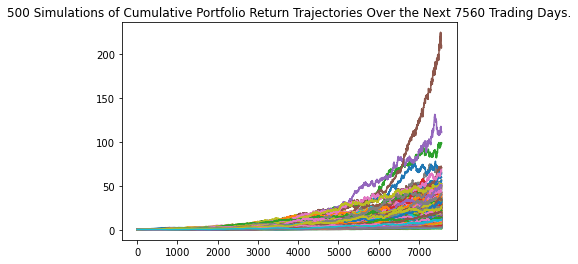

In [19]:
# Plot simulation outcomes
line_plot = MC_thirty_year.plot_simulation()

# Save the plot for future usage
line_plot.get_figure().savefig("MC_thirty_year_sim_plot.png", bbox_inches="tight")

In [ ]:
# Plot probability distribution and confidence intervals
dist_plot = MC_thirty_year.plot_distribution()

# Save the plot for future usage
dist_plot.get_figure().savefig('MC_thirty_year_dist_plot.png',bbox_inches='tight')

### Retirement Analysis

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_portfolio.summarize_cumulative_return()

# Print summary statistics
print(tbl)

### Calculate the expected portfolio return at the 95% lower and upper confidence intervals based on a `$20,000` initial investment.

In [ ]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [ ]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)


# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [ ]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
# Set number of simulations
num_sims = 500

# Configure a Monte Carlo simulation to forecast three years daily returns
MC_fiveyear = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.4,0.6],
    num_simulation = num_sims,
    num_trading_days = 252 * 5
)

In [ ]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_fiveyear.calc_cumulative_return()

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

In [ ]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

### Ten Years Retirement Option

In [ ]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

In [ ]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")